In [1]:
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
import numpy as np 
from ZeroNE import ZeroNE  
import matplotlib.pyplot as plt

In [2]:
#Circuits
qc1 = QuantumCircuit(2)
qc1.rx(3*np.pi/4, 0)  
qc1.ry(5*np.pi/6, 1) 



qc2 = QuantumCircuit(3)
qc2.rx(np.pi/5, 1)  
qc2.ry(np.pi/2, 2)  
qc2.rz(np.pi/3, 0)  

qc3=QuantumCircuit(3)
qc3.rz(np.pi/2, 1)  
qc3.rx(np.pi/7, 2)  
qc3.ry(3*np.pi/2, 0) 


In [3]:
#Observables
H1=SparsePauliOp.from_list([("IX", -3.4), ("ZI", -4.5), ("XX", -2.3)])
H2=SparsePauliOp.from_list([("IXI", 2.3), ("IZI",4.7), ("XIX", 3.8)])
H3=SparsePauliOp.from_list([("YIX", 2.3), ("IZY",4.7), ("ZXI", 3.8)])


In [4]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

# Noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit over the gates rx, ry, rz
error = depolarizing_error(0.3, 1)
noise_model.add_all_qubit_quantum_error(error,['rx', 'ry', 'rz'])
shots = 90000
#Simulators
simulator_ideal = Estimator( backend_options={'shots':shots,},
                                transpile_options={'optimization_level':0} ) 
simulator_noisy = Estimator( backend_options={'noise_model':noise_model, 
                                                'shots':shots,},
                                transpile_options={'optimization_level':0} ) 

In [5]:
circuits=[qc1,qc2,qc3]
observables = [H1 ,H2,H3]
#Here we evaluate the expectation values of the circuit [qc1,qc2,qc3] with respect
#the observables [H1,H2,H3] using the ideal and noisy simulators
for j in range(len(circuits)):
    print("For the circuit " + str(j + 1))
    qc = circuits[j]
    H = observables[j]
    
    # Ideal Simulator
    result_ideal = simulator_ideal.run(qc, H).result().values[0]
    print(f"The ideal expectation value is <H{j + 1}> = {result_ideal}")
    
    # Noisy Simulator
    result_noisy = simulator_noisy.run(qc, H).result().values[0]
    print(f"The noisy expectation value is <H{j + 1}> = {result_noisy}")

For the circuit 1
The ideal expectation value is <H1> = 3.873386666666667
The noisy expectation value is <H1> = 2.725817777777778
For the circuit 2
The ideal expectation value is <H2> = 3.8187533333333334
The noisy expectation value is <H2> = 2.6840444444444445
For the circuit 3
The ideal expectation value is <H3> = 0.9665644444444444
The noisy expectation value is <H3> = 0.09636666666666667


In [6]:
#We define our calculator and the scale factors
scale_factors0=[1., 1.5, 2.5, 3.,3.5,5.]
zeroNE_calculator=ZeroNE()


In [7]:
#we compare linear, quadratic and exponential interpolation

for j in range(len(circuits)):
    print("For the circuit " + str(j + 1)+" and operator H"+str(j+1))
    qc = circuits[j]
    H = observables[j]
    
    # Difference between the ideal and the ZNE values 
    IdealValue=simulator_ideal.run(qc, H).result().values[0]
    LinearZNEValue=zeroNE_calculator.ZeroNEPolynomial(
                          qc,
                          scale_factors0,
                          H,
                          simulator_noisy,degree=1)
    QuadraticZNEValue=zeroNE_calculator.ZeroNEPolynomial(
                          qc,
                          scale_factors0,
                          H,
                          simulator_noisy,degree=2)
    ExponentialZNEValue=zeroNE_calculator.ZeroNEExponential(
                          qc,
                          scale_factors0,
                          H,
                          simulator_noisy)
    DifferenceLinear = np.abs((IdealValue-LinearZNEValue)/IdealValue)
    
    print("Relative difference between ideal and LinearZNE =" +str(DifferenceLinear))
    DifferenceQuadratic = np.abs((IdealValue-QuadraticZNEValue)/(IdealValue))
    print("Relative difference between ideal and QuadraticZNE ="+str(DifferenceQuadratic))
    DifferenceExponential = np.abs((IdealValue-ExponentialZNEValue)/(IdealValue))
    print("Relative difference between ideal and ExponentialZNE =" +str(DifferenceExponential))

For the circuit 1 and operator H1
Relative difference between ideal and LinearZNE =0.1042305146889086
Relative difference between ideal and QuadraticZNE =1.12664764237392
Relative difference between ideal and ExponentialZNE =0.13486634033963268
For the circuit 2 and operator H2
Relative difference between ideal and LinearZNE =0.09258168344705897
Relative difference between ideal and QuadraticZNE =1.1189640154672
Relative difference between ideal and ExponentialZNE =0.12428724850583105
For the circuit 3 and operator H3
Relative difference between ideal and LinearZNE =0.8464554878056154
Relative difference between ideal and QuadraticZNE =1.0988528999531113
Relative difference between ideal and ExponentialZNE =0.8679016078729552


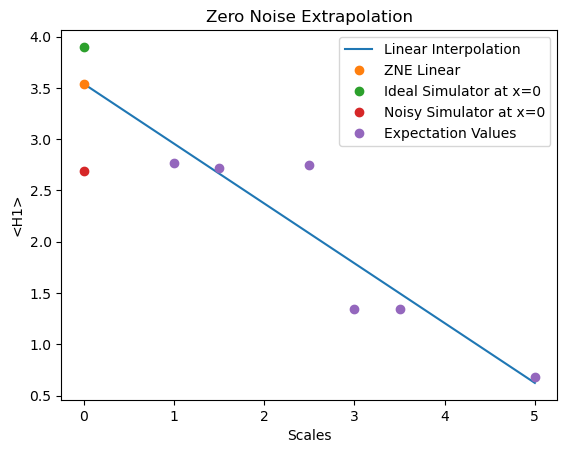

In [8]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Scales
x = [1., 1.5, 2.5, 3., 3.5, 5.]
# Operator H1 and circuit qc1
y = zeroNE_calculator.ExpectationValues(qc1, x, H1, simulator_noisy)

# Linear Interpolation
coefficients1 = np.polyfit(x, y, 1)
polynomial1 = np.poly1d(coefficients1)
zne_value_linear = polynomial1(0)
x_interpolated = np.linspace(0, 5, 100)
y_interpolated_linear = polynomial1(x_interpolated)

# Quadratic Interpolation
coefficients2 = np.polyfit(x, y, 2)
polynomial2 = np.poly1d(coefficients2)
zne_value_quadratic = polynomial2(0)
y_interpolated_quadratic = polynomial2(x_interpolated)

# Exponential Interpolation
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

popt, pcov = curve_fit(exponential_func, x, y)
zne_value_exponential = exponential_func(0, *popt)
y_interpolated_exponential = exponential_func(x_interpolated, *popt)

# Plot
plt.plot(x_interpolated, y_interpolated_linear, label='Linear Interpolation')
#plt.plot(x_interpolated, y_interpolated_quadratic, label='Quadratic Interpolation')
#plt.plot(x_interpolated, y_interpolated_exponential, label='Exponential Interpolation')
plt.plot(0, zne_value_linear, 'o', label='ZNE Linear')
#plt.plot(0, zne_value_quadratic, 'o', label='ZNE Quadratic')
#plt.plot(0, zne_value_exponential, 'o', label='ZNE Exponential')
plt.plot(0, simulator_ideal.run(qc1, H1).result().values[0], 'o', label='Ideal Simulator at x=0')
plt.plot(0, simulator_noisy.run(qc1, H1).result().values[0], 'o', label='Noisy Simulator at x=0')
plt.plot(x, y, 'o', label='Expectation Values')
plt.title('Zero Noise Extrapolation')
plt.xlabel('Scales')
plt.ylabel('<H1>')
plt.legend()
plt.show()